## Import Libraries

In [1]:
import sys
sys.path.append("..") # so we can import espresso from the directory above.
import os

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import bootstrap_contrast as bsc

import espresso as esp

/Users/josesho/anaconda3/envs/py3.6/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


## Create Espresso Instances

In [11]:
data_folder='/Users/josesho/bin/git-repos/espresso/data'

starved_choice_folder=os.path.join(data_folder,'24-Hrs-starved-choice')
mb312b_folder=os.path.join(data_folder,'by_genotype/MB312B')
mb213b_folder=os.path.join(data_folder,'by_genotype/MB213B')

starved_choice=esp.espresso(starved_choice_folder)
mb312b=esp.espresso(mb312b_folder)
mb213b=esp.espresso(mb213b_folder)

mbs=mb312b+mb213b

In [12]:
mbs

8 feedlogs with a total of 240 flies.
5 genotypes ['w1118;MB312B-Gal4' 'MB312B-Gal4>UAS-TrpA1' 'w1118;UAS-TrpA1'
 'w1118;MB213B-Gal4' 'MB213B-Gal4>UAS-TrpA1'].
2 temperatures [22 29].
2 foodtypes ['100mM_Sucrose' '100mM_Sucrose_100mM_Arabinose'].

## Plot Testing

Coloring feed volume time course by Genotype
Grouping feed volume time course by FoodChoice


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1121f9ac8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1112c9748>], dtype=object)

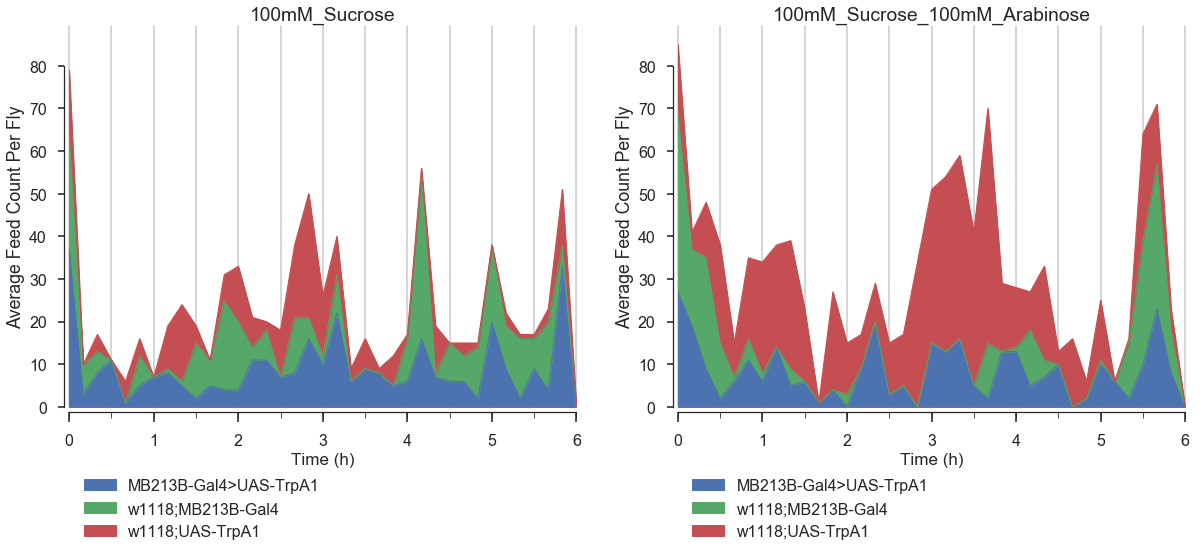

In [3]:
mb213b.plot.timecourse.feed_count(group_by='FoodChoice',color_by='Genotype')

Coloring feed volume time course by FoodChoice
Grouping feed volume time course by Genotype


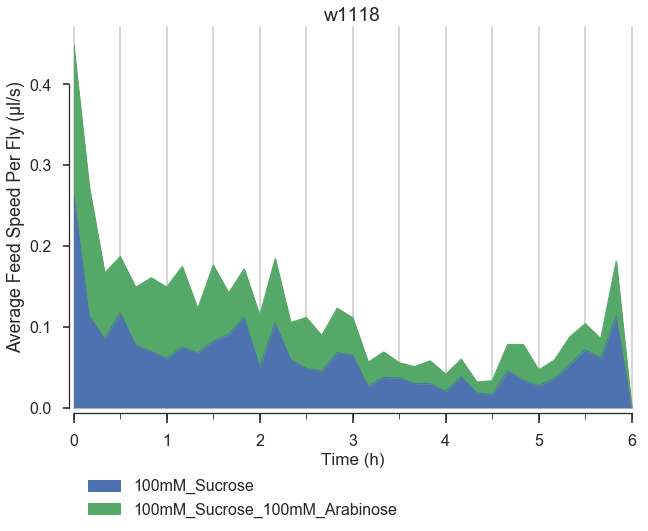

In [4]:
starved_choice.plot.timecourse.feed_speed()

Coloring feed volume time course by FoodChoice
Grouping feed volume time course by Genotype


array([<matplotlib.axes._subplots.AxesSubplot object at 0x111d7bd68>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x111552630>], dtype=object)

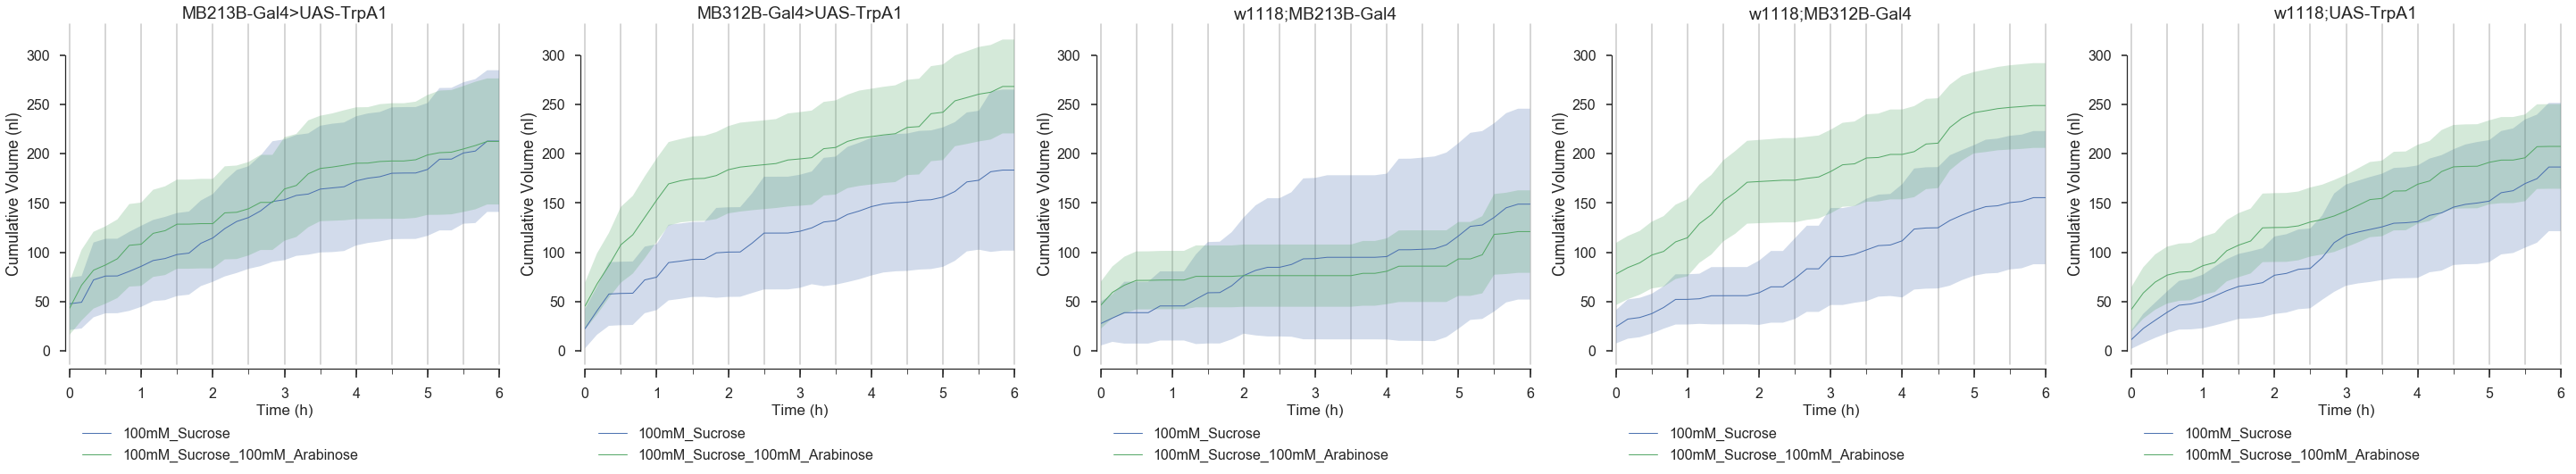

In [13]:
mbs.plot.cumulative.consumption()

Coloring feed volume time course by Temperature
Grouping feed volume time course by Genotype


array([<matplotlib.axes._subplots.AxesSubplot object at 0x111cbe9e8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x110fc0c50>], dtype=object)

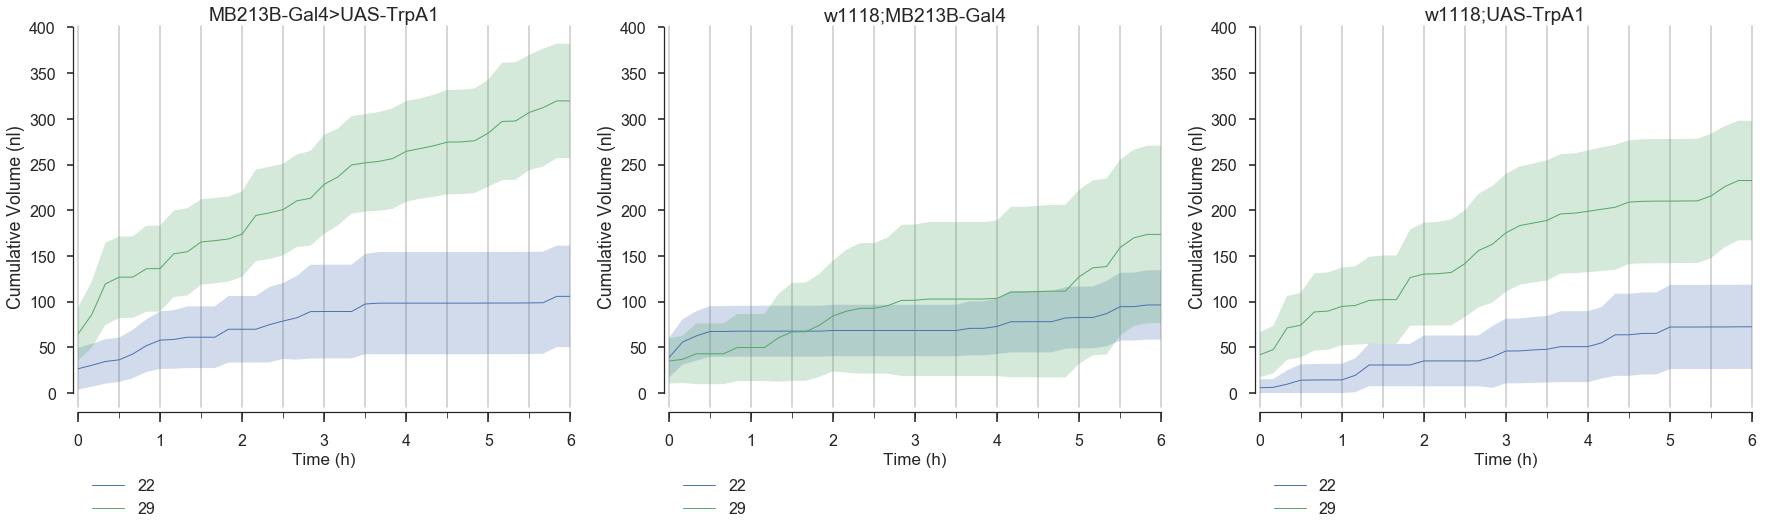

In [18]:
mb213b.plot.cumulative.consumption(group_by='Genotype',color_by='Temperature')

In [7]:
mb213b

4 feedlogs with a total of 120 flies.
3 genotypes ['w1118;MB213B-Gal4' 'MB213B-Gal4>UAS-TrpA1' 'w1118;UAS-TrpA1'].
2 temperatures [22 29].
2 foodtypes ['100mM_Sucrose' '100mM_Sucrose_100mM_Arabinose'].

## Used for Development

In [3]:
mb312b

4 feedlogs with a total of 120 flies.
3 genotypes ['w1118;MB312B-Gal4' 'MB312B-Gal4>UAS-TrpA1' 'w1118;UAS-TrpA1'].
2 temperatures [22 29].
2 foodtypes ['100mM_Sucrose' '100mM_Sucrose_100mM_Arabinose'].

In [10]:
df=mb312b.feeds.copy()

resample_by='10min'

yvar='Cumulative Feed Count'

#### NO NEED TO TWEAK ####
if df.RelativeTime_s.dtype=='float64':
    df.loc[:,'RelativeTime_s']=pd.to_datetime(df['RelativeTime_s'],unit='s')
    
# a=df.groupby(['Temperature','Genotype','FlyID','FoodChoice'])\
#                .resample(resample_by,on='RelativeTime_s')\
#                .sum()
# a=pd.DataFrame( a.to_records() )

In [13]:
b=df.groupby(['Temperature','Genotype','FlyID','FoodChoice'])\
    .resample(resample_by,on='RelativeTime_s')\
    .sum()\
    .groupby(['Temperature','Genotype','FlyID','FoodChoice'])\
    .cumsum()\
    .groupby(['Temperature','Genotype','FlyID','FoodChoice'])\
    .fillna(method='ffill')\
    .fillna(0)

b=pd.DataFrame( b.to_records() )

b=b[['Temperature','Genotype','FlyID','FoodChoice','RelativeTime_s',
     'AverageFeedVolumePerFly_µl','AverageFeedCountPerFly']]

b=esp._munger.__add_time_column(b)

b.rename(columns={'AverageFeedCountPerFly':'Cumulative Feed Count',
                  'AverageFeedVolumePerFly_µl':'Cumulative Consumption (µl)'},
           inplace=True)

In [71]:
b.columns

Index(['Temperature', 'Genotype', 'FlyID', 'FoodChoice', 'RelativeTime_s',
       'Cumulative Consumption (µl)', 'Cumulative Feed Count', 'time_s'],
      dtype='object')

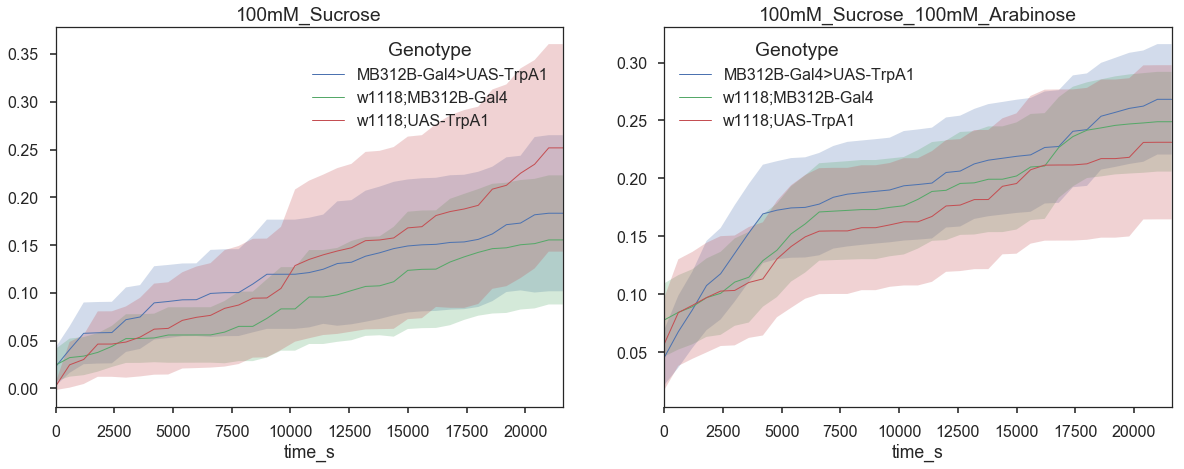

In [14]:
##### CUMULATIVE PLOT.

# plotdat=pd.DataFrame(a.to_records())
plotdat=b.copy()

group_by='FoodChoice'
color_by='Genotype'

# yvar='Cumulative Feed Count'
yvar='Cumulative Consumption (µl)'

sns.set(style='ticks',context='poster')
groupby_grps=np.sort( plotdat[group_by].unique() )
num_plots=int( len(groupby_grps) )

x_inches=10*num_plots
y_inches=7
    
fig,axx=plt.subplots(nrows=1,
                      ncols=num_plots,
                      figsize=(x_inches,y_inches),
                      gridspec_kw={'wspace':0.2} )

# Loop through each panel.
for c, grp in enumerate( groupby_grps ):
    if len(groupby_grps)>1:
        plotax=axx[c]
    else:
        plotax=axx
        
    ## Filter plotdf according to group_by.
    temp_plotdf=plotdat[plotdat[group_by]==grp]

    ### and make cumulative plot.
    temp_plotdf_groupby = temp_plotdf.groupby([color_by,'time_s'])
    temp_plotdf_mean = temp_plotdf_groupby.mean().unstack()[yvar].T
    temp_plotdf_mean.plot(ax=plotax,lw=1)

    temp_plotdf_halfci = temp_plotdf_groupby.sem().unstack()[yvar].T*1.96
    lower_ci = temp_plotdf_mean-temp_plotdf_halfci
    upper_ci = temp_plotdf_mean+temp_plotdf_halfci
    
    for c in temp_plotdf_mean.columns:
        plotax.fill_between(temp_plotdf_mean.index,
                         lower_ci[c],upper_ci[c],
                           alpha=0.25)
    plotax.set_title(grp)

In [21]:
lower_ci[lower_ci>0]='a'

In [22]:
lower_ci

Genotype,MB312B-Gal4>UAS-TrpA1,w1118;MB312B-Gal4,w1118;UAS-TrpA1
time_s,,,
0,a,a,a
600,a,a,a
1200,a,a,a
1800,a,a,a
2400,a,a,a
3000,a,a,a
3600,a,a,a
4200,a,a,a
4800,a,a,a
